## EDS 296: Final Mini-Project

Authors: Oksana Protsukha, Leilanie Rubinstein, & Naomi Moraes

This project is assigned as the final assignment for EDS 296 - taught by Dr. Sam Stevenson. In this project we will use geospatial and temporal analysis to investigate changing environmental factors in the western region of India.

### Western Coast of India

We have decided to focus the scope of our investigation into this region - as rising heatwaves (across India) are responsible for increasing numbers of public health impacts - like heat exhaustian, sunstroke, and dehydration. Coupled with the relief/exacerbation cycles of monsoon season - we decided to look at how air surface temperature and precipitation may impact this location over time.

[Maharashtra](images/westindia.png)

In [1]:
# Import packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore(
    "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"
)

# Convert the catalog to a df for easier access
cat_df = catalog.df

### Data I/O

We have chosen to use the CanESM5 and CESM2 models - due to abundance of data. As aforementioned we will be using 'tas' and 'pr'. We have also decided to use 'historical' and 'ssp245' experiment_ids, as well as 'r11i1p1f1' member_id - as these variables were found for the desired models and atmospheric variables.

In [3]:
# Specify search terms to query catalog

activity_ids = ["ScenarioMIP", "CMIP"]
source_id = ["CanESM5", "CESM2"]
table_id = "Amon"
variable_id = ["tas", "pr"]
member_id = ["r11i1p1f1"]
experiment_id = ["historical", "ssp245"]


In [4]:
res = catalog.search(
    activity_id=activity_ids,
    source_id=source_id,
    table_id=table_id,
    variable_id=variable_id,
    member_id=member_id,
    experiment_id=experiment_id,
)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
1,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
2,ScenarioMIP,CCCma,CanESM5,ssp245,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp245,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190514
5,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190514
6,ScenarioMIP,NCAR,CESM2,ssp245,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
7,ScenarioMIP,NCAR,CESM2,ssp245,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


In [5]:
# store historical data for CanESM5
CAN_hist_pr = xr.open_zarr(res.df["zstore"][0], storage_options={"anon": True})
CAN_hist_tas = xr.open_zarr(res.df["zstore"][1], storage_options={"anon": True})

# Store 245 scenario for CanESM5
CAN_245_pr = xr.open_zarr(res.df["zstore"][2], storage_options={"anon": True})
CAN_245_tas = xr.open_zarr(res.df["zstore"][3], storage_options={"anon": True})

# store historical data for CESM2
CESM_hist_pr = xr.open_zarr(res.df["zstore"][4], storage_options={"anon": True})
CESM_hist_tas = xr.open_zarr(res.df["zstore"][5], storage_options={"anon": True})

# Store 245 scenario for CESM2
CESM_245_pr = xr.open_zarr(res.df["zstore"][7], storage_options={"anon": True})
CESM_245_tas = xr.open_zarr(res.df["zstore"][6], storage_options={"anon": True})

In [30]:
# Concatenate stored data of historical and 245 scenarios - for both models and atmospheric variables

# CanESM5
CAN_pr = xr.concat([CAN_hist_pr, CAN_245_pr], dim="time")
CAN_tas = xr.concat([CAN_hist_tas, CAN_245_tas], dim="time")


# CESM2
CESM_pr = xr.concat([CESM_hist_pr, CESM_245_pr], dim="time")
CESM_tas = xr.concat([CESM_hist_tas, CESM_245_tas], dim="time")

### Compute metrics based on extracted data

In [31]:
# Compute change in precipitation over time for historical and 245 scenarios
# CanESM5
CAN_pr_time = CAN_pr.time.astype("datetime64[ns]")
CAN_tas_time = CAN_tas.time.astype("datetime64[ns]")

# Define min/max bounds for Maharashtra
# 15.61354340280576, 72.64918053500008, 22.02304881395156, 80.89700564999072
lat_min, lat_max = 15.61, 22.02
lon_min, lon_max = 72.65, 80.90

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
CAN_pr_lat = (CAN_pr.lat >= lat_min) & (CAN_pr.lat <= lat_max)
CAN_pr_lon = (CAN_pr.lon >= lon_min) & (CAN_pr.lon <= lon_max)

CAN_tas_lat = (CAN_tas.lat >= lat_min) & (CAN_tas.lat <= lat_max)
CAN_tas_lon = (CAN_tas.lon >= lon_min) & (CAN_tas.lon <= lon_max)

# Find points where the mask value is True, drop all other points
CAN_pr = CAN_pr.where(CAN_pr_lat & CAN_pr_lon, drop=True)
CAN_tas = CAN_tas.where(CAN_tas_lat & CAN_tas_lon, drop=True)

# Average over lat, lon dimensions to get a time series
CAN_pr = CAN_pr.mean(dim=["lat", "lon"])
CAN_tas = CAN_tas.mean(dim=["lat", "lon"])

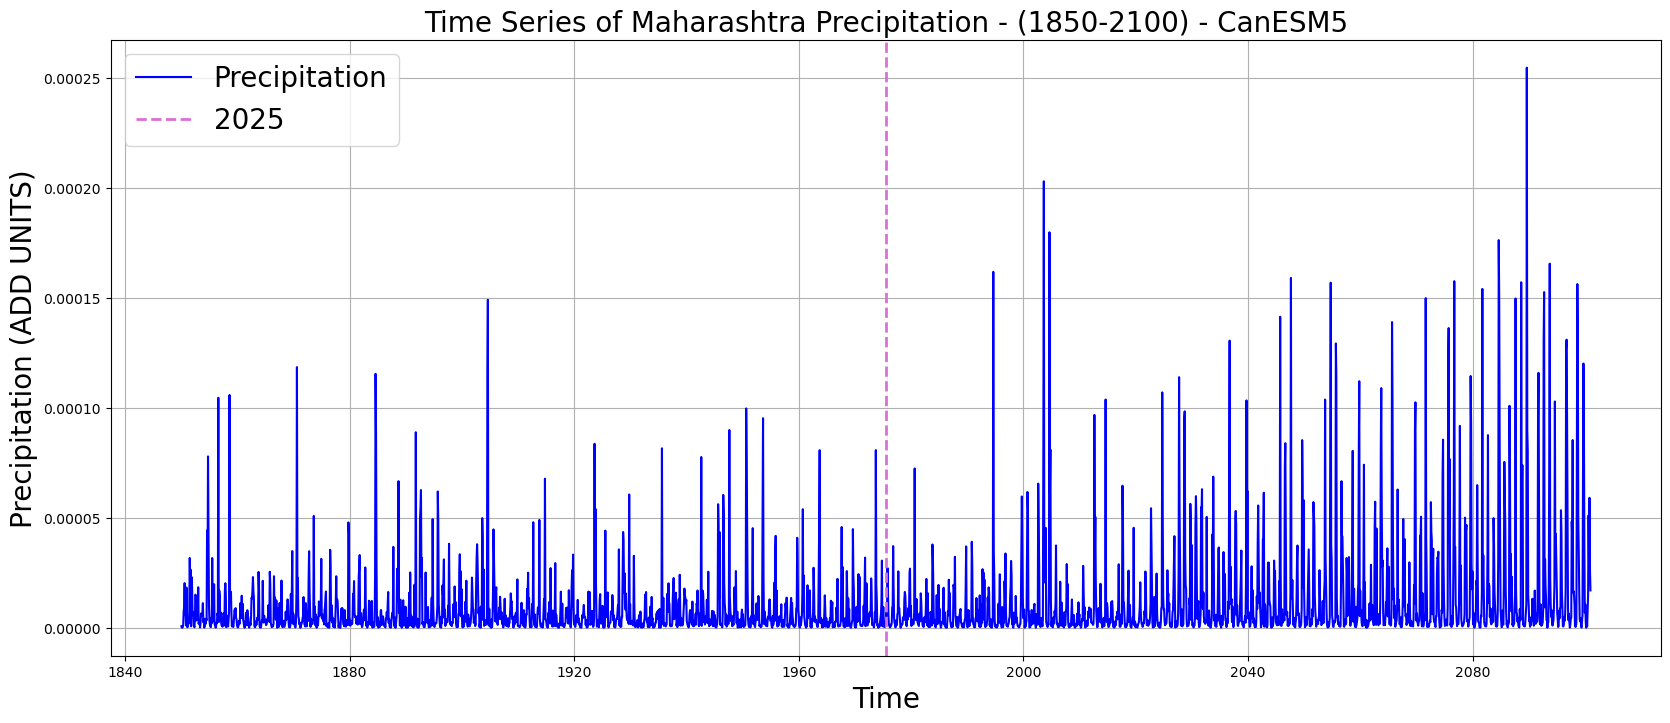

In [29]:
# Plot precipitation for CanESM5 model
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(CAN_pr_time, CAN_pr.pr, label="Precipitation", color="b")
ax.axvline(x=2025, color="orchid", linestyle="--", linewidth=2, label="2025")
ax.set_title(
    "Time Series of Maharashtra Precipitation - (1850-2100) - CanESM5", fontsize=20
)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation (ADD UNITS)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

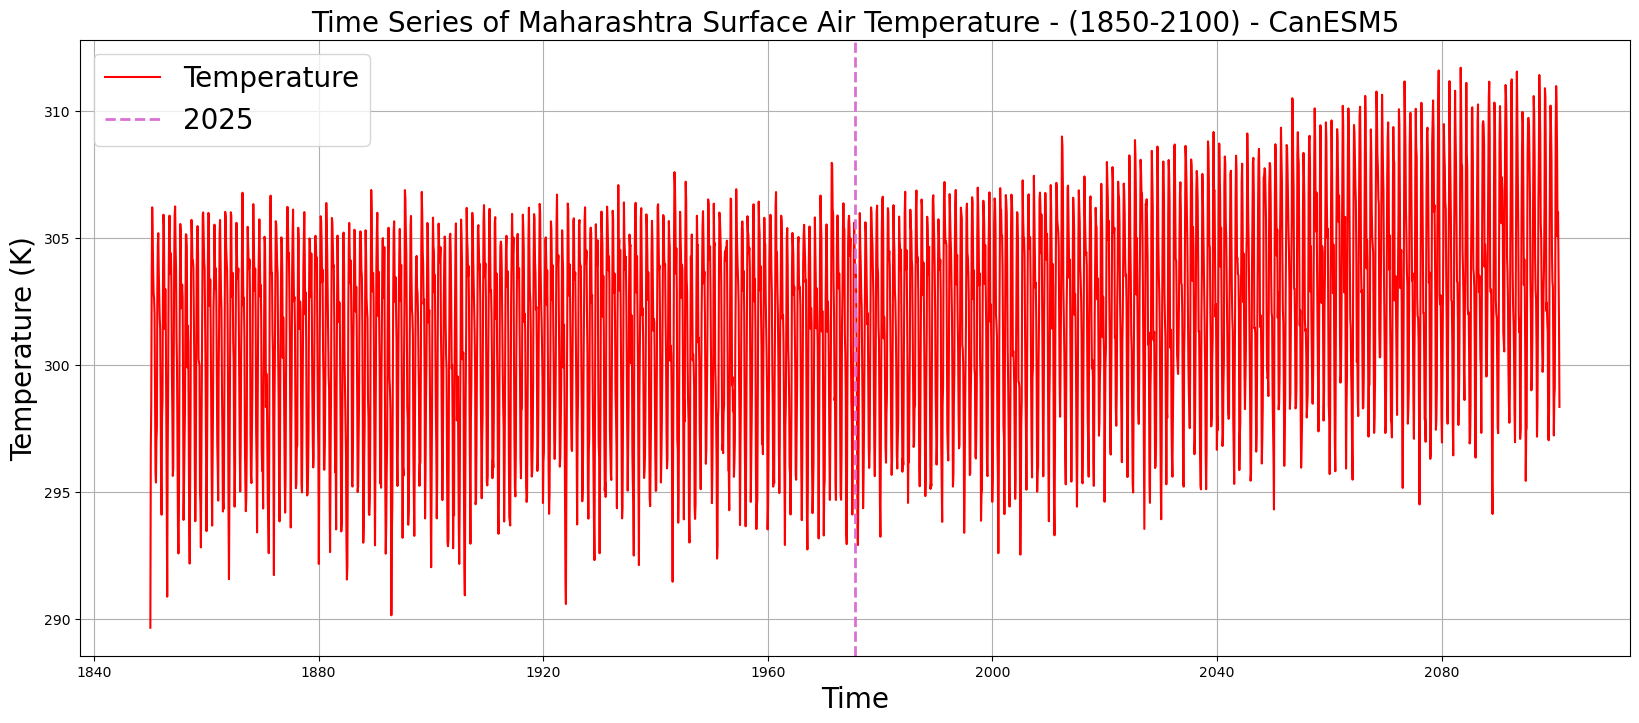

In [32]:
# Plot surface air temperature for CanESM5 model
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(CAN_tas_time, CAN_tas.tas, label="Temperature", color="red")
ax.axvline(x=2025, color="orchid", linestyle="--", linewidth=2, label="2025")
ax.set_title(
    "Time Series of Maharashtra Surface Air Temperature - (1850-2100) - CanESM5", fontsize=20
)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

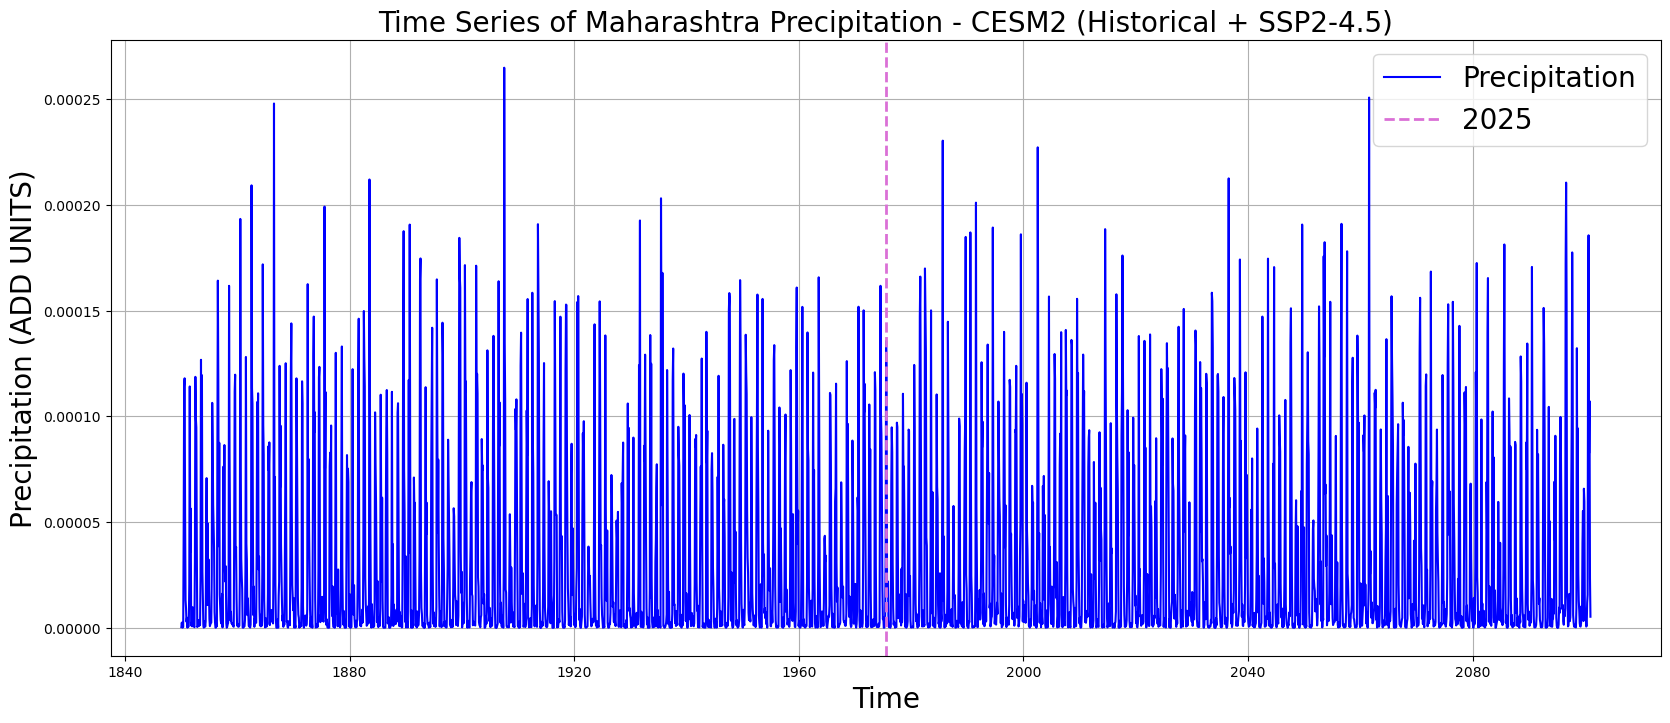

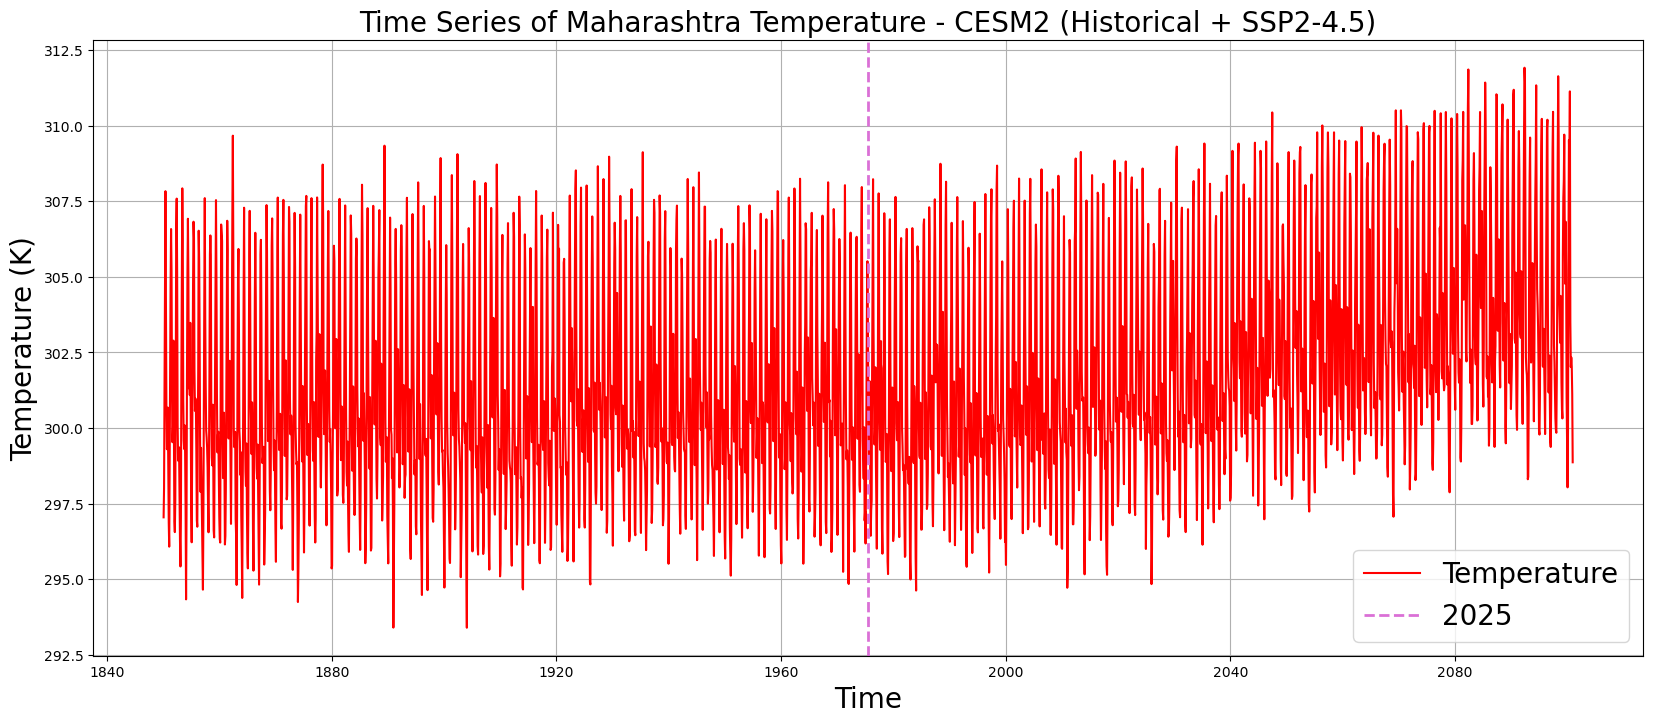

In [ ]:
# Create a functio to plot time series
def plot_climate_time_series(
    data, time_data, variable_name, model_name, lat_bounds, lon_bounds, scenario="245"
):
    """
    Plot time series for climate data

    Parameters:
    - data: xarray dataset
    - time_data: time dimension data
    - variable_name: 'pr' or 'tas'
    - model_name: model identifier (e.g., 'CanESM5', 'CESM2')
    - lat_bounds: (lat_min, lat_max)
    - lon_bounds: (lon_min, lon_max)
    - scenario: scenario identifier for title
    """
    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds

    # Apply spatial mask
    lat_mask = (data.lat >= lat_min) & (data.lat <= lat_max)
    lon_mask = (data.lon >= lon_min) & (data.lon <= lon_max)
    data_masked = data.where(lat_mask & lon_mask, drop=True)

    # Average over spatial dimensions
    data_avg = data_masked.mean(dim=["lat", "lon"])

    # Plot
    fig, ax = plt.subplots(figsize=(20, 8))

    if variable_name == "pr":
        ax.plot(time_data, data_avg.pr, label="Precipitation", color="blue")
        ylabel = "Precipitation (ADD UNITS)"
        title = f"Time Series of Maharashtra Precipitation - {model_name} ({scenario})"
    else:
        ax.plot(time_data, data_avg.tas, label="Temperature", color="red")
        ylabel = "Temperature (K)"
        title = f"Time Series of Maharashtra Surface Air Temperature - {model_name} ({scenario})"

    ax.axvline(x=2025, color="orchid", linestyle="--", linewidth=2, label="2025")
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Time", fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.legend(fontsize=20)
    ax.grid()
    plt.show()

    return data_avg


# Define bounds for Maharashtra
lat_bounds = (15.61, 22.02)
lon_bounds = (72.65, 80.90)

# Plot all scenarios
models = {
    "CESM2": {
        "pr": CESM_pr,
        "tas": CESM_tas,
        "time": CESM_tas.time.astype("datetime64[ns]"),
    },
}

# Generate all plots
for model_name, model_data in models.items():
    for var in ["pr", "tas"]:
        plot_climate_time_series(
            data=model_data[var],
            time_data=model_data["time"],
            variable_name=var,
            model_name=model_name,
            lat_bounds=lat_bounds,
            lon_bounds=lon_bounds,
            scenario="Historical + SSP2-4.5",
        )